# ***Using Dataset2 (smaller version)***

In [4]:
import os
import glob
import numpy as np
from PIL import Image
from google.colab import drive

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Define dataset paths
base_path = '/content/drive/MyDrive/Dataset2'
splits = {
    'Train': os.path.join(base_path, 'Train'),
    'Validate': os.path.join(base_path, 'Validate'),
    'Test': os.path.join(base_path, 'Test')
}
sigma = 15  # Noise level σ = 15
image_size = (128, 128)  # Resize to 128x128

In [7]:
# Verify folder existence
for split, path in splits.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Folder not found: {path}. Run the path listing code to confirm the correct path.")
    print(f"Found {split} folder: {path}")

Found Train folder: /content/drive/MyDrive/Dataset2/Train
Found Validate folder: /content/drive/MyDrive/Dataset2/Validate
Found Test folder: /content/drive/MyDrive/Dataset2/Test


In [8]:
# Function to add Gaussian noise
def add_gaussian_noise(image, sigma):
    img_array = np.array(image).astype(np.float32) / 255.0
    noise = np.random.normal(0, sigma / 255.0, img_array.shape)
    noisy_img = np.clip(img_array + noise, 0, 1) * 255.0
    return Image.fromarray(noisy_img.astype(np.uint8))

In [9]:
# Loop through dataset splits
for split in splits:
    clean_path = splits[split]
    # Collect clean images recursively (JPG or PNG)
    clean_files = sorted(glob.glob(os.path.join(clean_path, '**', '*.jpg'), recursive=True) +
                         glob.glob(os.path.join(clean_path, '**', '*.png'), recursive=True))
    clean_files = [f for f in clean_files if 'noisy_sigma' not in f]

    if not clean_files:
        raise ValueError(f"No images found in {clean_path}")

    print(f"Processing {split} with sigma={sigma} ({len(clean_files)} images)...")

    for clean_file in clean_files:
        # Load and resize image to 128x128 in RGB
        clean_img = Image.open(clean_file).convert('RGB').resize(image_size, Image.Resampling.LANCZOS)

        # Add Gaussian noise
        noisy_img = add_gaussian_noise(clean_img, sigma)

        # Construct output path
        rel_path = os.path.relpath(clean_file, clean_path)
        noisy_dir = os.path.join(clean_path, f'noisy_sigma{sigma}', os.path.dirname(rel_path))
        os.makedirs(noisy_dir, exist_ok=True)

        # Save noisy image as PNG
        output_file = os.path.join(noisy_dir, os.path.basename(clean_file).rsplit('.', 1)[0] + '.png')
        noisy_img.save(output_file, 'PNG')

        # Optionally resize and save clean image as PNG
        clean_output_file = os.path.join(clean_path, rel_path.rsplit('.', 1)[0] + '.png')
        os.makedirs(os.path.dirname(clean_output_file), exist_ok=True)
        clean_img.save(clean_output_file, 'PNG')

    print(f"Saved {len(clean_files)} noisy (sigma={sigma}) and clean images to {clean_path}")

print("All done! Noisy and clean RGB images (128x128, sigma=15) are saved in each split.")

Processing Train with sigma=15 (504 images)...
Saved 504 noisy (sigma=15) and clean images to /content/drive/MyDrive/Dataset2/Train
Processing Validate with sigma=15 (102 images)...
Saved 102 noisy (sigma=15) and clean images to /content/drive/MyDrive/Dataset2/Validate
Processing Test with sigma=15 (108 images)...
Saved 108 noisy (sigma=15) and clean images to /content/drive/MyDrive/Dataset2/Test
All done! Noisy and clean RGB images (128x128, sigma=15) are saved in each split.


# ***Training part:***

In [10]:
import os
import glob
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from google.colab import drive
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import sys


In [13]:
# Copy dataset to local disk
local_base_path = '/content/New'
if not os.path.exists(local_base_path):
    print("📂 Copying dataset to local disk for faster I/O...")
    !cp -r /content/drive/MyDrive/Dataset2 /content/New
base_path = local_base_path

📂 Copying dataset to local disk for faster I/O...


In [14]:
# Define dataset paths
splits = {
    'train': os.path.join(base_path, 'Train'),
    'validate': os.path.join(base_path, 'Validate'),
    'test': os.path.join(base_path, 'Test')
}
sigma = 15  # Use σ = 15 images

In [15]:
# Verify folder existence
for split, path in splits.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Folder not found: {path}")
    noisy_path = os.path.join(path, f'noisy_sigma{sigma}')
    if not os.path.exists(noisy_path):
        raise FileNotFoundError(f"Noisy folder not found: {noisy_path}")
    print(f"📂 Found {split} folder: {path}")


📂 Found train folder: /content/New/Train
📂 Found validate folder: /content/New/Validate
📂 Found test folder: /content/New/Test


In [16]:
# PairedNoisyCleanDataset for RGB images
class PairedNoisyCleanDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.transform = transform
        split_dir = os.path.join(base_dir, split.capitalize())
        noisy_dir = os.path.join(split_dir, f'noisy_sigma{sigma}')

        # Collect clean images (excluding noisy_sigma15)
        self.clean_images = []
        for root, _, files in os.walk(split_dir):
            if os.path.abspath(root) == os.path.abspath(noisy_dir):
                continue
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    self.clean_images.append(os.path.join(root, f))

        # Collect noisy images
        self.noisy_images = [
            os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ]

        # Match pairs by filename
        clean_dict = {os.path.basename(p): p for p in self.clean_images}
        noisy_dict = {os.path.basename(p): p for p in self.noisy_images}
        self.matched_clean = []
        self.matched_noisy = []
        for fname in noisy_dict:
            if fname in clean_dict:
                self.matched_clean.append(clean_dict[fname])
                self.matched_noisy.append(noisy_dict[fname])
            else:
                print(f"⚠️ Warning: No matching clean image for noisy file {fname}")

        print(f"📊 [{split}] Found {len(self.matched_clean)} paired samples")
        if len(self.matched_clean) == 0:
            raise ValueError(f"No matched pairs found in {split} dataset!")

        # Print first 5 clean and noisy images
        print(f"🖼️ First 5 clean images for {split}:")
        for img in self.matched_clean[:5]:
            print(f"  - {img}")
        print(f"🖼️ First 5 noisy images for {split}:")
        for img in self.matched_noisy[:5]:
            print(f"  - {img}")

    def __len__(self):
        return len(self.matched_clean)

    def __getitem__(self, idx):
        noisy_img = Image.open(self.matched_noisy[idx]).convert('RGB')
        clean_img = Image.open(self.matched_clean[idx]).convert('RGB')

        if self.transform:
            seed = torch.randint(0, 2**31, (1,)).item()
            torch.manual_seed(seed)
            noisy_img = self.transform(noisy_img)
            torch.manual_seed(seed)
            clean_img = self.transform(clean_img)

        return noisy_img, clean_img


In [17]:
# Define transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(64),  # 64x64 crops from 128x128
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()  # [3, 64, 64], [0, 1]
])
val_test_transform = transforms.ToTensor()  # [3, 128, 128]

In [18]:
# Create datasets and dataloaders
batch_size = 8  # Reduced for CPU
train_dataset = PairedNoisyCleanDataset(base_path, 'train', train_transform)
val_dataset = PairedNoisyCleanDataset(base_path, 'validate', val_test_transform)
test_dataset = PairedNoisyCleanDataset(base_path, 'test', val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"📈 Train dataset size: {len(train_dataset)}")
print(f"📈 Validation dataset size: {len(val_dataset)}")
print(f"📈 Test dataset size: {len(test_dataset)}")

📊 [train] Found 504 paired samples
🖼️ First 5 clean images for train:
  - /content/New/Train/00031.png
  - /content/New/Train/00042.png
  - /content/New/Train/00386.png
  - /content/New/Train/00322.png
  - /content/New/Train/00021.png
🖼️ First 5 noisy images for train:
  - /content/New/Train/noisy_sigma15/00031.png
  - /content/New/Train/noisy_sigma15/00042.png
  - /content/New/Train/noisy_sigma15/00386.png
  - /content/New/Train/noisy_sigma15/00322.png
  - /content/New/Train/noisy_sigma15/00021.png
📊 [validate] Found 102 paired samples
🖼️ First 5 clean images for validate:
  - /content/New/Validate/00673.png
  - /content/New/Validate/00623.png
  - /content/New/Validate/00641.png
  - /content/New/Validate/00689.png
  - /content/New/Validate/00624.png
🖼️ First 5 noisy images for validate:
  - /content/New/Validate/noisy_sigma15/00673.png
  - /content/New/Validate/noisy_sigma15/00623.png
  - /content/New/Validate/noisy_sigma15/00641.png
  - /content/New/Validate/noisy_sigma15/00689.png
 

In [19]:
# Debug: Inspect batch structure
for batch in train_loader:
    print("🔍 Batch type:", type(batch))
    print("🔍 Batch length:", len(batch))
    for i, item in enumerate(batch):
        print(f"🔍 Item {i} shape: {item.shape}")
    break

🔍 Batch type: <class 'list'>
🔍 Batch length: 2
🔍 Item 0 shape: torch.Size([8, 3, 64, 64])
🔍 Item 1 shape: torch.Size([8, 3, 64, 64])


In [20]:
# Bi-MSAAE Model with Batch Normalization
class MultiScaleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3),  # Depthwise
            nn.Conv2d(3, 32, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=5, padding=2, groups=3),  # Depthwise
            nn.Conv2d(3, 32, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        f1 = self.branch3x3(x)  # [batch, 32, H, W]
        f2 = self.branch5x5(x)  # [batch, 32, H, W]
        return torch.cat([f1, f2], dim=1)  # [batch, 64, H, W]

class NoiseGateModule(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mask = self.conv(x)  # [batch, 1, H, W]
        mask = self.sigmoid(mask)
        return x * mask  # [batch, 64, H, W]

class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)  # [batch, 64, 1, 1]
        max_out = self.max_pool(x)  # [batch, 64, 1, 1]
        pooled = torch.cat([avg_out, max_out], dim=1)  # [batch, 128, 1, 1]
        attn = self.conv(pooled)  # [batch, 64, 1, 1]
        attn = self.sigmoid(attn)
        return x * attn  # [batch, 64, H, W]

class DualHeadDecoder(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.structural_head = nn.Sequential(
            nn.Conv2d(in_channels, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3)
        )
        self.texture_head = nn.Sequential(
            nn.Conv2d(in_channels, 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(3)
        )
        self.alpha = 0.6

    def forward(self, x):
        struct = self.structural_head(x)  # [batch, 3, H, W]
        text = self.texture_head(x)  # [batch, 3, H, W]
        return self.alpha * struct + (1 - self.alpha) * text  # [batch, 3, H, W]

class BiMSAAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MultiScaleEncoder()
        self.noise_gate = NoiseGateModule()
        self.attention = ChannelAttentionBlock()
        self.decoder = DualHeadDecoder()
        self.skip_conv = nn.Conv2d(64, 64, kernel_size=1)

    def forward(self, x):
        f = self.encoder(x)  # [batch, 64, H, W]
        skip = self.skip_conv(f)
        f = self.noise_gate(f)
        f = self.attention(f)
        f = f + skip
        out = self.decoder(f)
        return torch.sigmoid(out)  # [batch, 3, H, W]

In [21]:
# Animated Epoch Logger
GREEN = "\033[92m"
YELLOW = "\033[93m"
CYAN = "\033[96m"
RESET = "\033[0m"

def animated_epoch_update(epoch, num_epochs, train_loss, val_loss, psnr, ssim, epoch_time, lr):
    bar_len = 30
    filled_len = int(round(bar_len * (epoch + 1) / num_epochs))
    bar = '█' * filled_len + ' ' * (bar_len - filled_len)
    sys.stdout.write(f"\r{CYAN}Epoch {epoch+1}/{num_epochs} [{bar}] {100*(epoch+1)/num_epochs:.1f}%{RESET}")
    sys.stdout.flush()
    time.sleep(0.1)
    print(f"\n🌟 Training Progress:")
    print(f"  🏋️‍♂️ Train Loss: {train_loss:.6f}")
    print(f"  📉 Val Loss  : {val_loss:.6f}")
    print(f"  📷 PSNR      : {psnr:.2f} dB")
    print(f"  🔍 SSIM      : {ssim:.4f}")
    print(f"  ⏱️ Epoch Time: {epoch_time:.2f} sec")
    print(f"  ⚙️ LR        : {lr:.6e}")
    print("═" * 50)


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import sys
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Colors for terminal output
CYAN = '\033[96m'
RESET = '\033[0m'

# Fallback if animated_epoch_update() is not defined
def animated_epoch_update(epoch, num_epochs, train_loss, val_loss, psnr, ssim, epoch_time, lr):
    print(f"{CYAN}Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.1f}s{RESET}")
    print(f"   🏋️  Train Loss: {train_loss:.4f}")
    if not (val_loss != val_loss):  # check for NaN
        print(f"   🔍 Val Loss: {val_loss:.4f} | PSNR: {psnr:.2f} | SSIM: {ssim:.4f}")
    print(f"   🔁 LR: {lr:.6f}")

# Your model must be defined earlier as class BiMSAAE(nn.Module)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    model.to(device)
    train_dataset = train_loader.dataset
    val_dataset = val_loader.dataset
    total_train_batches = len(train_loader)
    batch_size = train_loader.batch_size or 1  # Fallback if undefined

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        for i, batch in enumerate(train_loader):
            noisy, clean = batch
            noisy, clean = noisy.to(device), clean.to(device)
            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * noisy.size(0)

            # Print progress every 100 batches
            if (i + 1) % 100 == 0 or (i + 1) == total_train_batches:
                sys.stdout.write(
                    f"\r{CYAN}Epoch {epoch+1}/{num_epochs} | Batch {i+1}/{total_train_batches} "
                    f"[{100*(i+1)/total_train_batches:.1f}%]{RESET}"
                )
                sys.stdout.flush()

        # Validation every 5 epochs or last
        val_loss, psnr_val, ssim_val = float('nan'), float('nan'), float('nan')
        if epoch % 5 == 4 or epoch == num_epochs - 1:
            model.eval()
            val_loss, psnr_val, ssim_val = 0.0, 0.0, 0.0
            with torch.no_grad():
                val_subset = list(val_loader)[:max(1, len(val_loader) // 5)]
                for noisy, clean in val_subset:
                    noisy, clean = noisy.to(device), clean.to(device)
                    outputs = model(noisy)
                    loss = criterion(outputs, clean)
                    val_loss += loss.item() * noisy.size(0)
                    outputs_np = outputs.cpu().numpy()
                    clean_np = clean.cpu().numpy()
                    for i in range(outputs_np.shape[0]):
                        psnr_channels = [
                            peak_signal_noise_ratio(clean_np[i, c], outputs_np[i, c], data_range=1.0)
                            for c in range(outputs_np.shape[1])
                        ]
                        ssim_channels = [
                            structural_similarity(clean_np[i, c], outputs_np[i, c], data_range=1.0)
                            for c in range(outputs_np.shape[1])
                        ]
                        psnr_val += sum(psnr_channels) / len(psnr_channels)
                        ssim_val += sum(ssim_channels) / len(ssim_channels)

                # Safe divide
                n_val = min(len(val_dataset), len(val_subset) * batch_size)
                val_loss /= n_val
                psnr_val /= n_val
                ssim_val /= n_val

            scheduler.step(val_loss)

        avg_train_loss = train_loss / len(train_dataset)
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']

        # Print animated or default update
        animated_epoch_update(epoch, num_epochs, avg_train_loss, val_loss, psnr_val, ssim_val, epoch_time, current_lr)

        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f'/content/drive/MyDrive/bi_msaae_model_sigma15_128x128_epoch{epoch+1}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"💾 Checkpoint saved to {checkpoint_path}")

        # Early stopping
        if psnr_val > 28 and ssim_val > 0.8 and epoch >= 20:
            print(f"🎯 Target metrics (PSNR > 28, SSIM > 0.8) achieved at epoch {epoch+1}. Stopping training.")
            break

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and training setup
model = BiMSAAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)  # verbose removed
num_epochs = 50

In [26]:
# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs)

Epoch 1/50 | Batch 63/63 [100.0%]Epoch [1/50] - Time: 3.9s
   🏋️  Train Loss: 0.0410
   🔁 LR: 0.000100
Epoch 2/50 | Batch 63/63 [100.0%]Epoch [2/50] - Time: 2.6s
   🏋️  Train Loss: 0.0167
   🔁 LR: 0.000100
Epoch 3/50 | Batch 63/63 [100.0%]Epoch [3/50] - Time: 1.8s
   🏋️  Train Loss: 0.0147
   🔁 LR: 0.000100
Epoch 4/50 | Batch 63/63 [100.0%]Epoch [4/50] - Time: 1.5s
   🏋️  Train Loss: 0.0146
   🔁 LR: 0.000100
Epoch 5/50 | Batch 63/63 [100.0%]Epoch [5/50] - Time: 2.0s
   🏋️  Train Loss: 0.0131
   🔍 Val Loss: 0.0129 | PSNR: 20.17 | SSIM: 0.7272
   🔁 LR: 0.000100
💾 Checkpoint saved to /content/drive/MyDrive/bi_msaae_model_sigma15_128x128_epoch5.pth
Epoch 6/50 | Batch 63/63 [100.0%]Epoch [6/50] - Time: 1.6s
   🏋️  Train Loss: 0.0129
   🔁 LR: 0.000100
Epoch 7/50 | Batch 63/63 [100.0%]Epoch [7/50] - Time: 1.5s
   🏋️  Train Loss: 0.0123
   🔁 LR: 0.000100
Epoch 8/50 | Batch 63/63 [100.0%]Epoch [8/50] - Time: 1.6s
   🏋️  Train Loss: 0.0121
   🔁 LR: 0.000100
Epoch 9/50 | Batch 63/63 [100.0%]Epoch

In [27]:
# Save final model
model_path = '/content/drive/MyDrive/bi_msaae_model_sigma15_128x128.pth'
torch.save(model.state_dict(), model_path)
print(f"✅ Training complete. Model saved to {model_path}")

✅ Training complete. Model saved to /content/drive/MyDrive/bi_msaae_model_sigma15_128x128.pth


In [28]:
# Test evaluation with inference time
model.eval()
test_loss, psnr_test, ssim_test, inference_times = 0.0, 0.0, 0.0, []
with torch.no_grad():
    for noisy, clean in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        start_time = time.time()
        outputs = model(noisy)
        inference_times.append((time.time() - start_time) * 1000 / noisy.size(0))
        loss = criterion(outputs, clean)
        test_loss += loss.item() * noisy.size(0)
        outputs_np = outputs.cpu().numpy()
        clean_np = clean.cpu().numpy()
        for i in range(outputs_np.shape[0]):
            psnr_channels = [
                peak_signal_noise_ratio(clean_np[i, c], outputs_np[i, c], data_range=1.0)
                for c in range(3)
            ]
            ssim_channels = [
                structural_similarity(clean_np[i, c], outputs_np[i, c], data_range=1.0)
                for c in range(3)
            ]
            psnr_test += sum(psnr_channels) / 3
            ssim_test += sum(ssim_channels) / 3

avg_test_loss = test_loss / len(test_dataset)
avg_psnr_test = psnr_test / len(test_dataset)
avg_ssim_test = ssim_test / len(test_dataset)
avg_inference_time = sum(inference_times) / len(inference_times)
print(f"📊 Test Results:")
print(f"  🏋️‍♂️ Test Loss: {avg_test_loss:.6f}")
print(f"  📷 Test PSNR: {avg_psnr_test:.2f} dB")
print(f"  🔍 Test SSIM: {avg_ssim_test:.4f}")
print(f"  ⏱️ Avg Inference Time: {avg_inference_time:.2f} ms")

📊 Test Results:
  🏋️‍♂️ Test Loss: 0.003518
  📷 Test PSNR: 25.45 dB
  🔍 Test SSIM: 0.8364
  ⏱️ Avg Inference Time: 0.95 ms


🖼️ Saving first 5 test images:
  - Noisy: /content/drive/MyDrive/denoised_samples_rgb_sigma15/noisy_0.png
  - Clean: /content/drive/MyDrive/denoised_samples_rgb_sigma15/clean_0.png
  - Denoised: /content/drive/MyDrive/denoised_samples_rgb_sigma15/denoised_0.png
  - Noisy: /content/drive/MyDrive/denoised_samples_rgb_sigma15/noisy_1.png
  - Clean: /content/drive/MyDrive/denoised_samples_rgb_sigma15/clean_1.png
  - Denoised: /content/drive/MyDrive/denoised_samples_rgb_sigma15/denoised_1.png
  - Noisy: /content/drive/MyDrive/denoised_samples_rgb_sigma15/noisy_2.png
  - Clean: /content/drive/MyDrive/denoised_samples_rgb_sigma15/clean_2.png
  - Denoised: /content/drive/MyDrive/denoised_samples_rgb_sigma15/denoised_2.png
  - Noisy: /content/drive/MyDrive/denoised_samples_rgb_sigma15/noisy_3.png
  - Clean: /content/drive/MyDrive/denoised_samples_rgb_sigma15/clean_3.png
  - Denoised: /content/drive/MyDrive/denoised_samples_rgb_sigma15/denoised_3.png
  - Noisy: /content/drive/MyDrive/denoised_sa

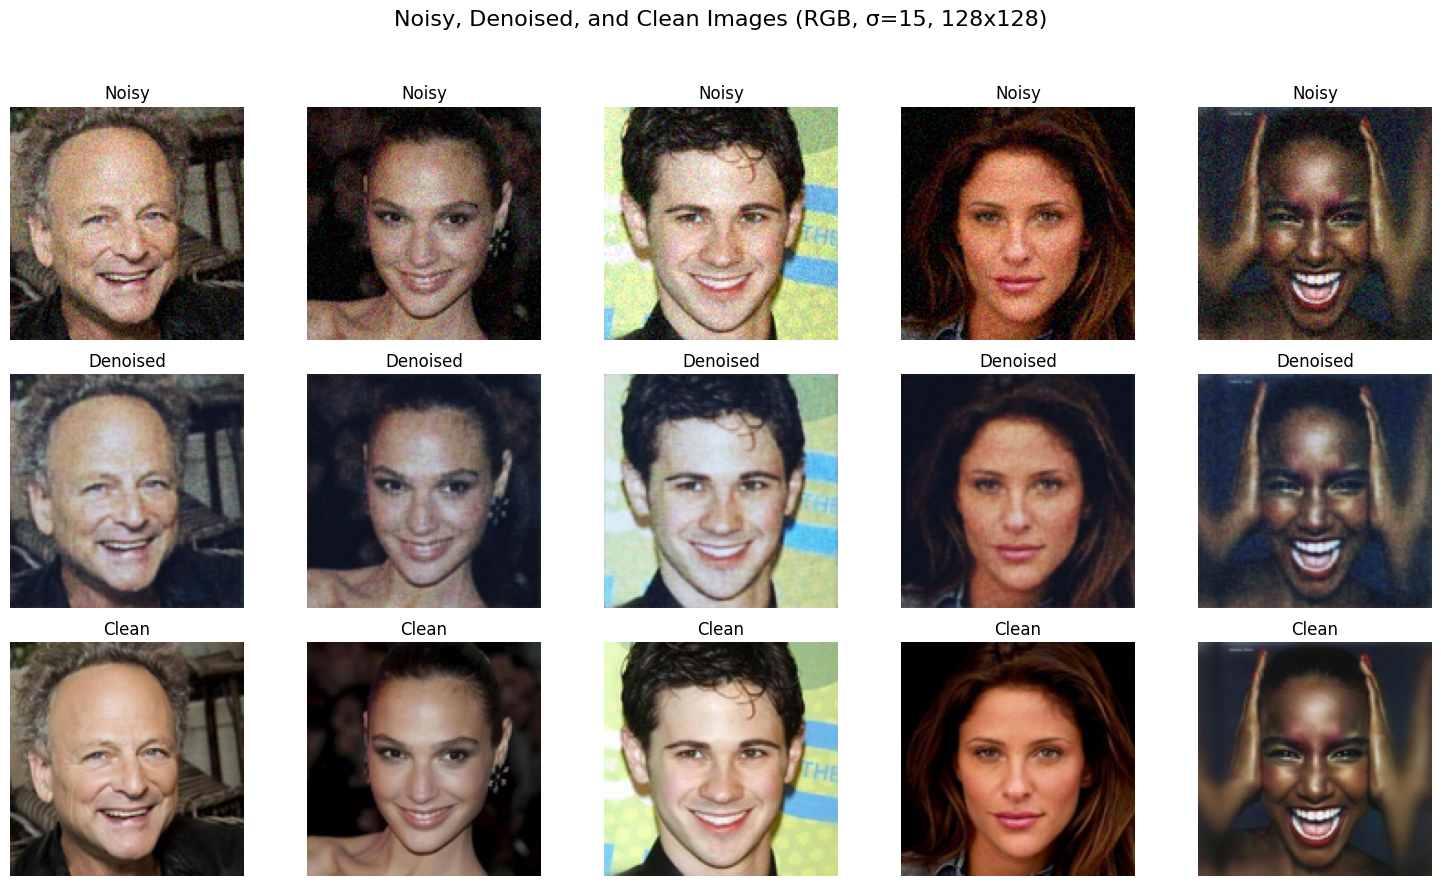

✅ Denoised samples saved to /content/drive/MyDrive/denoised_samples_rgb_sigma15


In [29]:
# Save and display 5 denoised images
os.makedirs('/content/drive/MyDrive/denoised_samples_rgb_sigma15', exist_ok=True)
model.eval()
with torch.no_grad():
    for i, (noisy, clean) in enumerate(test_loader):
        noisy = noisy.to(device)
        outputs = model(noisy)
        print(f"🖼️ Saving first 5 test images:")
        for j in range(min(5, noisy.size(0))):
            noisy_path = f'/content/drive/MyDrive/denoised_samples_rgb_sigma15/noisy_{j}.png'
            clean_path = f'/content/drive/MyDrive/denoised_samples_rgb_sigma15/clean_{j}.png'
            denoised_path = f'/content/drive/MyDrive/denoised_samples_rgb_sigma15/denoised_{j}.png'
            vutils.save_image(noisy[j], noisy_path)
            vutils.save_image(clean[j], clean_path)
            vutils.save_image(outputs[j], denoised_path)
            print(f"  - Noisy: {noisy_path}")
            print(f"  - Clean: {clean_path}")
            print(f"  - Denoised: {denoised_path}")

        # Display
        fig, axes = plt.subplots(3, 5, figsize=(15, 9))
        fig.suptitle('Noisy, Denoised, and Clean Images (RGB, σ=15, 128x128)', fontsize=16)
        for j in range(min(5, noisy.size(0))):
            axes[0, j].imshow(noisy[j].cpu().permute(1, 2, 0).numpy())
            axes[0, j].set_title('Noisy', fontsize=12)
            axes[0, j].axis('off')
            axes[1, j].imshow(outputs[j].cpu().permute(1, 2, 0).numpy())
            axes[1, j].set_title('Denoised', fontsize=12)
            axes[1, j].axis('off')
            axes[2, j].imshow(clean[j].cpu().permute(1, 2, 0).numpy())
            axes[2, j].set_title('Clean', fontsize=12)
            axes[2, j].axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        break

print("✅ Denoised samples saved to /content/drive/MyDrive/denoised_samples_rgb_sigma15")

# ***More evalutation ***

In [30]:
import numpy as np
from collections import defaultdict
import seaborn as sns

In [31]:
# Extended Evaluation
model.eval()
test_losses, psnr_per_image, ssim_per_image = [], [], []
psnr_per_channel = defaultdict(list)
ssim_per_channel = defaultdict(list)
inference_times = []
worst_cases = []

print("📊 Running extended evaluation on test set...")

with torch.no_grad():
    for batch_idx, (noisy, clean) in enumerate(test_loader):
        noisy, clean = noisy.to(device), clean.to(device)
        start_time = time.time()
        outputs = model(noisy)
        inference_times.append((time.time() - start_time) * 1000 / noisy.size(0))
        loss = criterion(outputs, clean)

        outputs_np = outputs.cpu().numpy()
        clean_np = clean.cpu().numpy()

        for i in range(outputs_np.shape[0]):
            test_losses.append(loss.item())
            psnr_channels = [
                peak_signal_noise_ratio(clean_np[i, c], outputs_np[i, c], data_range=1.0)
                for c in range(3)
            ]
            ssim_channels = [
                structural_similarity(clean_np[i, c], outputs_np[i, c], data_range=1.0)
                for c in range(3)
            ]
            avg_psnr = sum(psnr_channels) / 3
            avg_ssim = sum(ssim_channels) / 3
            psnr_per_image.append(avg_psnr)
            ssim_per_image.append(avg_ssim)

            for c, channel in enumerate(['R', 'G', 'B']):
                psnr_per_channel[channel].append(psnr_channels[c])
                ssim_per_channel[channel].append(ssim_channels[c])

            # Track worst cases
            worst_cases.append((avg_psnr, noisy[i], outputs[i], clean[i], batch_idx * batch_size + i))

📊 Running extended evaluation on test set...


In [32]:
# Per-Channel Metrics
print("\n📈 Per-Channel Metrics (Test Set):")
for channel in ['R', 'G', 'B']:
    print(f"  {channel} Channel:")
    print(f"    PSNR: {np.mean(psnr_per_channel[channel]):.2f} ± {np.std(psnr_per_channel[channel]):.2f} dB")
    print(f"    SSIM: {np.mean(ssim_per_channel[channel]):.4f} ± {np.std(ssim_per_channel[channel]):.4f}")



📈 Per-Channel Metrics (Test Set):
  R Channel:
    PSNR: 24.51 ± 1.42 dB
    SSIM: 0.8615 ± 0.0448
  G Channel:
    PSNR: 28.90 ± 1.96 dB
    SSIM: 0.8526 ± 0.0621
  B Channel:
    PSNR: 22.94 ± 1.43 dB
    SSIM: 0.7952 ± 0.0773


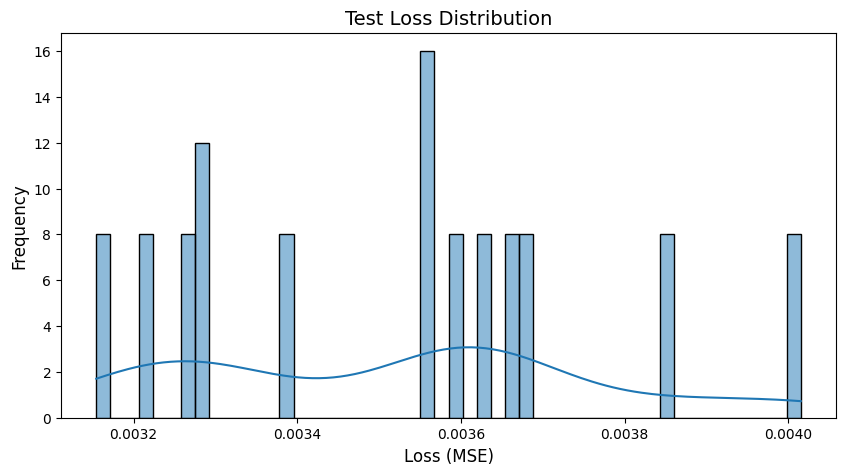

📊 Loss histogram saved to /content/drive/MyDrive/denoised_samples_rgb_sigma15/test_loss_histogram.png


In [33]:

# Loss Distribution
plt.figure(figsize=(10, 5))
sns.histplot(test_losses, bins=50, kde=True)
plt.title('Test Loss Distribution', fontsize=14)
plt.xlabel('Loss (MSE)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('/content/drive/MyDrive/denoised_samples_rgb_sigma15/test_loss_histogram.png')
plt.show()
print("📊 Loss histogram saved to /content/drive/MyDrive/denoised_samples_rgb_sigma15/test_loss_histogram.png")


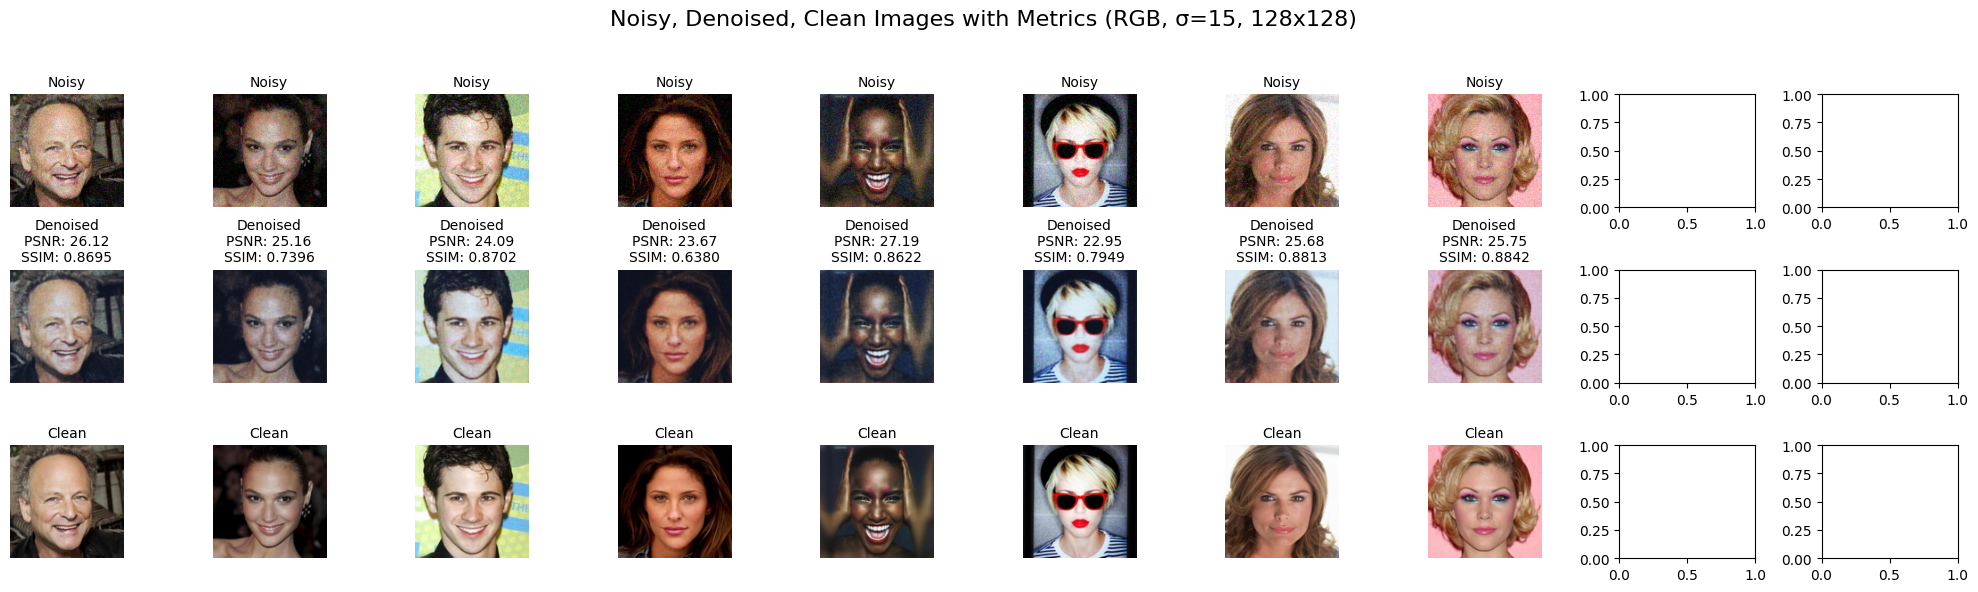

🖼️ Extended visual comparison saved to /content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/visual_comparison.png


In [34]:
# Visual Comparison (10 Images)
os.makedirs('/content/drive/MyDrive/denoised_samples_rgb_sigma15/extended', exist_ok=True)
with torch.no_grad():
    for i, (noisy, clean) in enumerate(test_loader):
        noisy = noisy.to(device)
        outputs = model(noisy)
        for j in range(min(10, noisy.size(0))):
            idx = i * batch_size + j
            psnr_val = psnr_per_image[idx]
            ssim_val = ssim_per_image[idx]

            noisy_path = f'/content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/noisy_{idx}.png'
            clean_path = f'/content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/clean_{idx}.png'
            denoised_path = f'/content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/denoised_{idx}.png'

            vutils.save_image(noisy[j], noisy_path)
            vutils.save_image(clean[j], clean_path)
            vutils.save_image(outputs[j], denoised_path)

        # Display
        fig, axes = plt.subplots(3, 10, figsize=(20, 6))
        fig.suptitle('Noisy, Denoised, Clean Images with Metrics (RGB, σ=15, 128x128)', fontsize=16)
        for j in range(min(10, noisy.size(0))):
            idx = i * batch_size + j
            psnr_val = psnr_per_image[idx]
            ssim_val = ssim_per_image[idx]

            axes[0, j].imshow(noisy[j].cpu().permute(1, 2, 0).numpy())
            axes[0, j].set_title('Noisy', fontsize=10)
            axes[0, j].axis('off')

            axes[1, j].imshow(outputs[j].cpu().permute(1, 2, 0).numpy())
            axes[1, j].set_title(f'Denoised\nPSNR: {psnr_val:.2f}\nSSIM: {ssim_val:.4f}', fontsize=10)
            axes[1, j].axis('off')

            axes[2, j].imshow(clean[j].cpu().permute(1, 2, 0).numpy())
            axes[2, j].set_title('Clean', fontsize=10)
            axes[2, j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig('/content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/visual_comparison.png')
        plt.show()
        print("🖼️ Extended visual comparison saved to /content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/visual_comparison.png")
        break


In [35]:
# Inference Time Breakdown
print("\n⏱️ Inference Time Analysis:")
print(f"  Mean: {np.mean(inference_times):.2f} ms")
print(f"  Std : {np.std(inference_times):.2f} ms")
print(f"  Min : {np.min(inference_times):.2f} ms")
print(f"  Max : {np.max(inference_times):.2f} ms")


⏱️ Inference Time Analysis:
  Mean: 0.84 ms
  Std : 0.66 ms
  Min : 0.24 ms
  Max : 2.21 ms



🔍 Worst-Performing Images (Lowest PSNR):
  Image 71: PSNR = 22.73 dB, SSIM = 0.7702
  Image 81: PSNR = 22.86 dB, SSIM = 0.5850
  Image 5: PSNR = 22.95 dB, SSIM = 0.7949
  Image 46: PSNR = 22.97 dB, SSIM = 0.7339
  Image 86: PSNR = 23.40 dB, SSIM = 0.8261


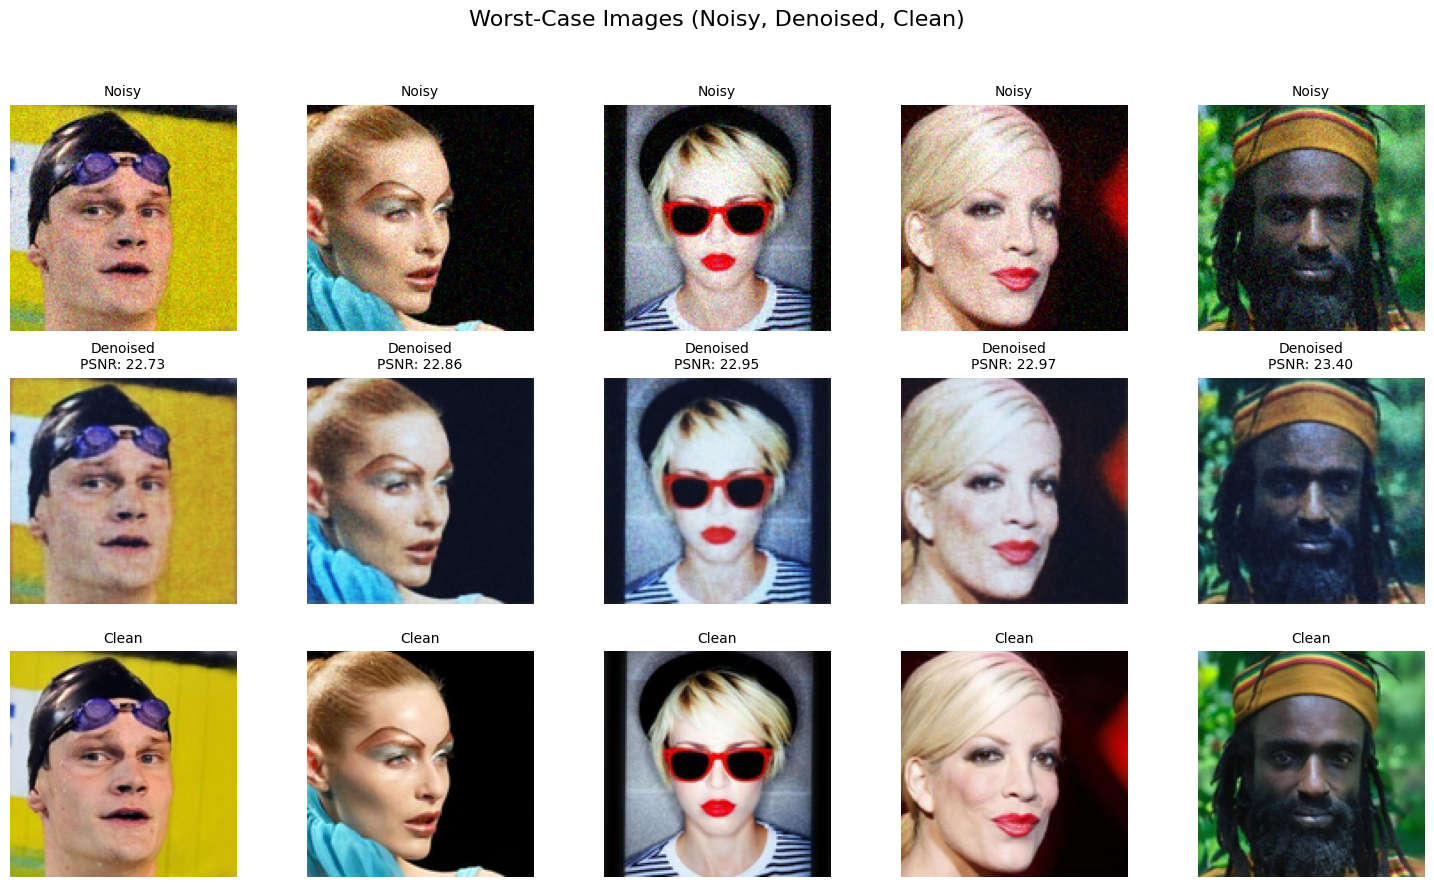

🖼️ Worst-case images saved to /content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/


In [36]:
# Worst-Case Analysis
worst_cases = sorted(worst_cases, key=lambda x: x[0])[:5]  # 5 lowest PSNR
print("\n🔍 Worst-Performing Images (Lowest PSNR):")
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Worst-Case Images (Noisy, Denoised, Clean)', fontsize=16)
for idx, (psnr, noisy, denoised, clean, img_idx) in enumerate(worst_cases):
    print(f"  Image {img_idx}: PSNR = {psnr:.2f} dB, SSIM = {ssim_per_image[img_idx]:.4f}")

    noisy_path = f'/content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/worst_noisy_{img_idx}.png'
    denoised_path = f'/content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/worst_denoised_{img_idx}.png'
    clean_path = f'/content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/worst_clean_{img_idx}.png'

    vutils.save_image(noisy, noisy_path)
    vutils.save_image(denoised, denoised_path)
    vutils.save_image(clean, clean_path)

    axes[0, idx].imshow(noisy.cpu().permute(1, 2, 0).numpy())
    axes[0, idx].set_title('Noisy', fontsize=10)
    axes[0, idx].axis('off')

    axes[1, idx].imshow(denoised.cpu().permute(1, 2, 0).numpy())
    axes[1, idx].set_title(f'Denoised\nPSNR: {psnr:.2f}', fontsize=10)
    axes[1, idx].axis('off')

    axes[2, idx].imshow(clean.cpu().permute(1, 2, 0).numpy())
    axes[2, idx].set_title('Clean', fontsize=10)
    axes[2, idx].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('/content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/worst_cases.png')
plt.show()
print("🖼️ Worst-case images saved to /content/drive/MyDrive/denoised_samples_rgb_sigma15/extended/")


In [38]:
# Model Parameter Count
total_params = sum(p.numel() for p in model.parameters())
print(f"\n🛠️ Model Parameters: {total_params:,} (~{total_params/1e6:.2f}M)")



🛠️ Model Parameters: 19,519 (~0.02M)


In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
from torchsummary import summary

In [49]:
!pip install torchsummary

In [51]:
# Print model architecture
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\n🛠️ Total Parameters: {total_params:,} (~{total_params/1e6:.2f}M)")

BiMSAAE(
  (encoder): MultiScaleEncoder(
    (branch3x3): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
      (1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (branch5x5): Sequential(
      (0): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=3)
      (1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
  )
  (noise_gate): NoiseGateModule(
    (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (attention): ChannelAttentionBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  

In [53]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

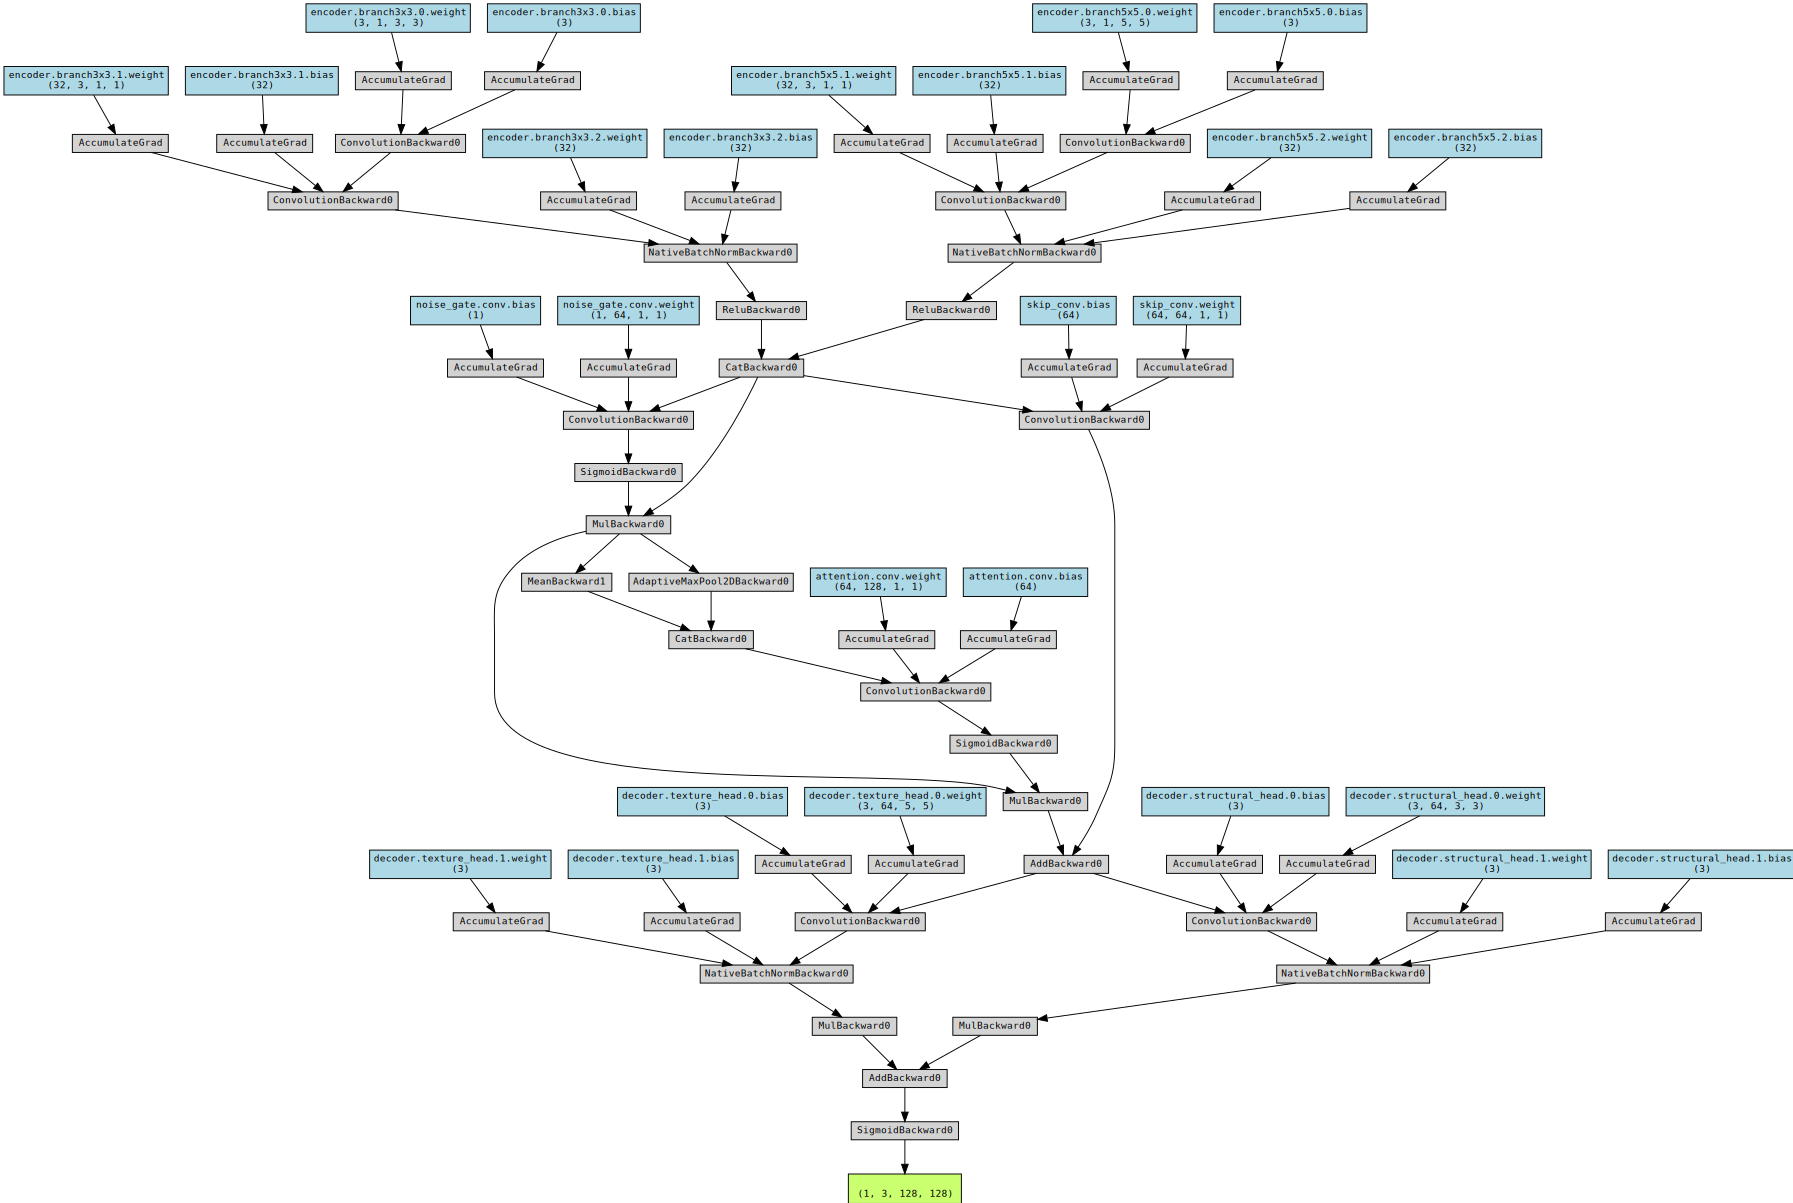

In [54]:
from torchviz import make_dot
import torch

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 128, 128).to(next(model.parameters()).device)

# Forward pass through model to get output
model.eval()
output = model(dummy_input)

# Create graph
dot = make_dot(output, params=dict(model.named_parameters()))

# Render and display the graph (requires graphviz installed on system)
dot.render('model_graph', format='png')  # saves as model_graph.png
dot  # this displays in Jupyter/Colab output

In [55]:
print(f"{'Layer':40} {'Shape':25} {'Params':10}")
print("="*80)
for name, param in model.named_parameters():
    print(f"{name:40} {str(list(param.shape)):25} {param.numel():10,}")

total_params = sum(p.numel() for p in model.parameters())
print("="*80)
print(f"Total parameters: {total_params:,} (~{total_params/1e6:.2f}M)")

Layer                                    Shape                     Params    
encoder.branch3x3.0.weight               [3, 1, 3, 3]                      27
encoder.branch3x3.0.bias                 [3]                                3
encoder.branch3x3.1.weight               [32, 3, 1, 1]                     96
encoder.branch3x3.1.bias                 [32]                              32
encoder.branch3x3.2.weight               [32]                              32
encoder.branch3x3.2.bias                 [32]                              32
encoder.branch5x5.0.weight               [3, 1, 5, 5]                      75
encoder.branch5x5.0.bias                 [3]                                3
encoder.branch5x5.1.weight               [32, 3, 1, 1]                     96
encoder.branch5x5.1.bias                 [32]                              32
encoder.branch5x5.2.weight               [32]                              32
encoder.branch5x5.2.bias                 [32]                   